# EDA and intial testing of LSTM on QQQ v SPX strategy

In [57]:
%matplotlib inline

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import copy

from sklearn.preprocessing import MinMaxScaler, Normalizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import Input


In [58]:
tickers = [
    '^GSPC',  # S&P 500
    '^IXIC',  # NASDAQ
#     'GSPX.L', 
#     'EQGB.L',  
]

yday = datetime.now() - timedelta(1)
start_date = '1990-01-01'
end_date = yday.strftime('%Y-%m-%d')

panel_data = data.DataReader(tickers , 'yahoo', start_date, end_date)
close_data = panel_data.loc[:, ('Close', slice(None))]
close_data.columns = close_data.columns.droplevel()

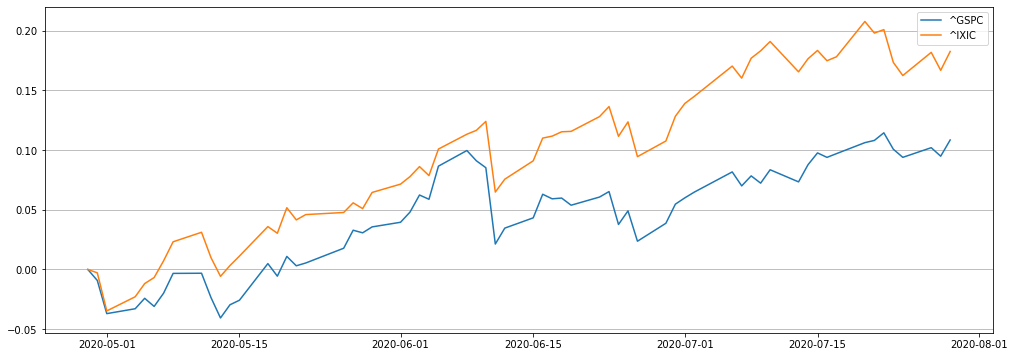

In [59]:
# titles = close_data.columns
chart_data = close_data.iloc[-64:, :].pct_change()
chart_data.iloc[0, :] = 0
chart_data = np.cumprod(1 + chart_data) - 1

plt.figure(figsize = (17,6))
plt.plot(chart_data[tickers])
plt.grid(axis = 'y')
plt.legend(tickers, loc = 'best');

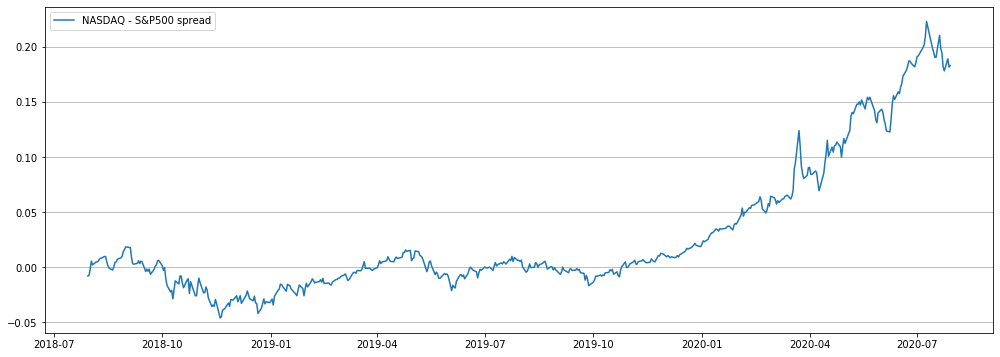

In [60]:
period = 505
nasdaq_v_spx = close_data.iloc[-period:, 1].pct_change() - close_data.iloc[-period:, 0].pct_change()
nasdaq_v_spx = np.cumprod(1 + nasdaq_v_spx) - 1

plt.figure(figsize = (17,6))
plt.plot(nasdaq_v_spx, label = 'NASDAQ - S&P500 spread')
plt.grid(axis = 'y')
plt.legend(loc = 'best');

___
# LSTM

- Use LSTM model
- Inputs: weekly spread between QQQ and SPX over different time windows
- Target: weekly spread

In [61]:
pct_nasdaq_v_spx = (close_data.iloc[:, 1].pct_change() - close_data.iloc[:, 0].pct_change()).fillna(0)
cum_nasdaq_v_spx = np.cumprod(1 + pct_nasdaq_v_spx) - 1

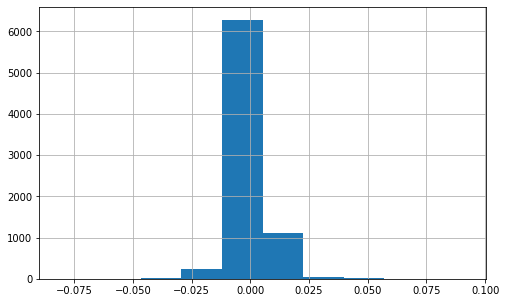

In [62]:
pct_nasdaq_v_spx.hist(figsize = (8, 5));

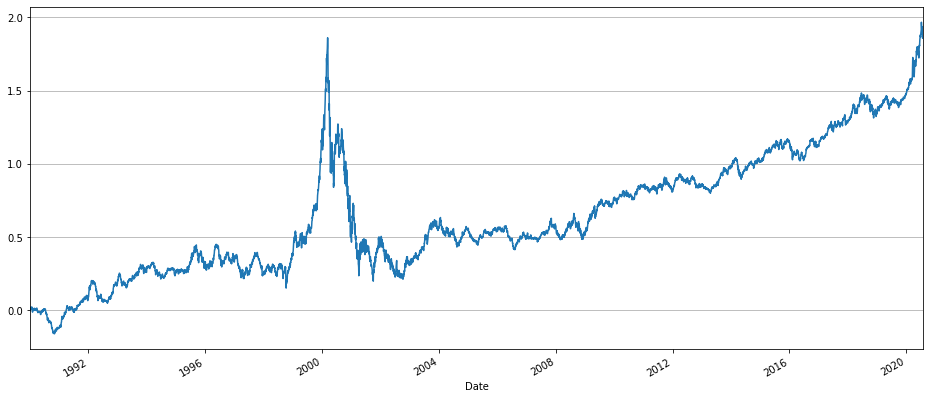

In [63]:
cum_nasdaq_v_spx.plot(figsize = (16, 7))
plt.grid(axis = 'y');

In [64]:
wkly_nsdq_v_spx = (cum_nasdaq_v_spx + 1).resample('W-FRI').last()
pct_wkly_nsdq_v_spx = wkly_nsdq_v_spx.pct_change().fillna(0) ## for now just doing friday close to friday close

Max weekly return: 0.11306082914061255
Min weekly return: -0.16150905753141065


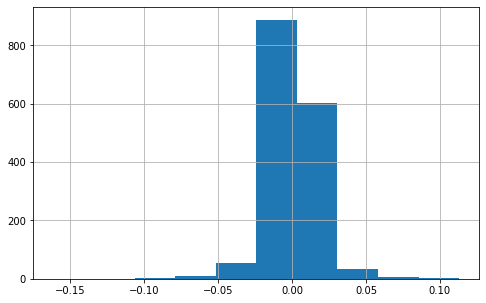

In [65]:
pct_wkly_nsdq_v_spx.hist(figsize = (8, 5));
print('Max weekly return:', np.max(pct_wkly_nsdq_v_spx))
print('Min weekly return:', np.min(pct_wkly_nsdq_v_spx))

## Train Test Split

In [66]:
# pct_wkly_nsdq_v_spx.shape[0]

In [67]:
# train_len = pct_wkly_nsdq_v_spx.shape[0] - 60 
train_len = wkly_nsdq_v_spx.shape[0] - (52 * 5)

# train = pct_wkly_nsdq_v_spx.iloc[:train_len].values.reshape(-1, 1)
# test = pct_wkly_nsdq_v_spx.iloc[train_len:].values.reshape(-1, 1)
train = wkly_nsdq_v_spx.iloc[:train_len].values.reshape(-1, 1)
test = wkly_nsdq_v_spx.iloc[train_len:].values.reshape(-1, 1)


train.shape, test.shape

((1336, 1), (260, 1))

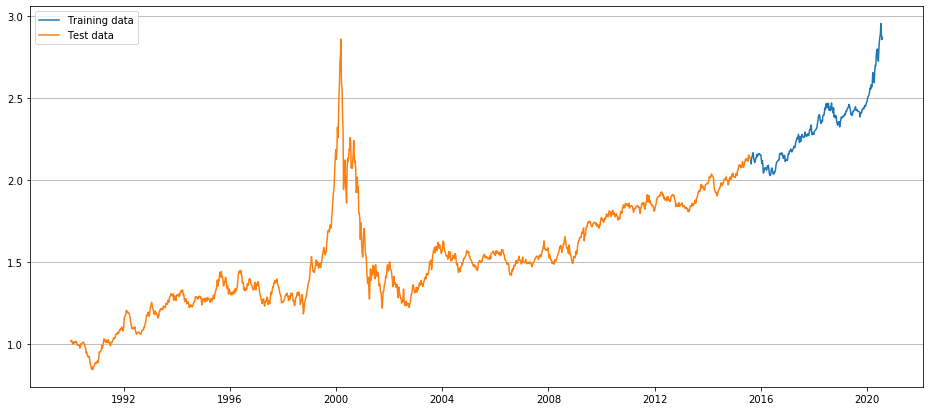

In [68]:
train_chart_data = copy.deepcopy(wkly_nsdq_v_spx)
test_chart_data = copy.deepcopy(wkly_nsdq_v_spx)

train_chart_data.iloc[:train_len] = np.nan
test_chart_data.iloc[train_len:] = np.nan

plt.figure(figsize = (16, 7))
plt.plot(train_chart_data, label = 'Training data')
plt.plot(test_chart_data, label = 'Test data')
plt.legend()
plt.grid(axis = 'y');

Is it important that the test data set has some visual similarity to the training data set? The first testing done used the most recent 60 weeks as the test set. This period saw the spread between QQQ and SPX increase much faster than the general trend. The second run had a test set that was about 3 times larger.

In [69]:
# plt.figure(figsize = (16, 14))
# plt.subplot(211)
# plt.plot(wkly_nsdq_v_spx.iloc[:train_len])
# plt.grid(axis = 'y')
# plt.subplot(212)
# plt.plot(wkly_nsdq_v_spx.iloc[train_len:])
# plt.grid(axis = 'y');

## Scale Data

In [70]:
scaler = MinMaxScaler()

scaler.fit(train) # ONLY FIT TO TRAINING DATA
scaled_train = scaler.transform(train) # each column ranges from 0 to 1
scaled_test = scaler.transform(test)

scaled_train.max(), scaled_test.max()

(1.0, 1.046837434328555)

## Time Series Generator
- `n_inputs` = the rolling window length (number of weeks)
- `n_cols` = the number of columns being trained (for univariate time-series, this is 1)

In [71]:
n_input = 52 # a smaller number of inputs than the test set size will lead to predictions based on predicted values
n_cols = scaled_train.shape[1]

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [72]:
# What does the first batch look like?
X, y = generator[0]

print(f'Given the Array: \n{X}')
print(f'Predict this y: \n {y}')

Given the Array: 
[[[0.08725221]
  [0.08425994]
  [0.08673244]
  [0.08391931]
  [0.07720955]
  [0.08082631]
  [0.08234924]
  [0.08416985]
  [0.08036153]
  [0.08340131]
  [0.08366648]
  [0.0849889 ]
  [0.07885197]
  [0.07337806]
  [0.07336946]
  [0.07470871]
  [0.07449419]
  [0.07312472]
  [0.06445883]
  [0.07201058]
  [0.07798969]
  [0.07517125]
  [0.07991156]
  [0.08123662]
  [0.08259065]
  [0.08219255]
  [0.07961842]
  [0.07580115]
  [0.06953624]
  [0.06694189]
  [0.0508968 ]
  [0.05318566]
  [0.04711904]
  [0.03905026]
  [0.04003644]
  [0.03785053]
  [0.03992787]
  [0.03297801]
  [0.01829099]
  [0.01427785]
  [0.00521124]
  [0.00035672]
  [0.00715935]
  [0.        ]
  [0.00415199]
  [0.01055344]
  [0.01095327]
  [0.01353741]
  [0.02092639]
  [0.01894753]
  [0.01806089]
  [0.01922742]]]
Predict this y: 
 [[0.02486927]]


## Create the model

In [73]:
# # define model
# model = Sequential()

# model.add(LSTM(300, activation = 'relu', input_shape = (n_input, n_cols)))
# model.add(Dense(1))
# model.compile(optimizer = 'adam', loss = 'mse')
# model.summary()

In [74]:
# define model
model = Sequential()

model.add(LSTM(300, activation = 'relu', return_sequences = True, input_shape = (n_input, n_cols)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(300, activation = 'relu', return_sequences = True))
model.add(Dropout(rate = 0.2))

# model.add(LSTM(100, activation = 'relu', return_sequences = True))
# model.add(Dropout(rate = 0.2))

model.add(LSTM(300, activation = 'relu', return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 52, 300)           362400    
_________________________________________________________________
dropout_34 (Dropout)         (None, 52, 300)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 52, 300)           721200    
_________________________________________________________________
dropout_35 (Dropout)         (None, 52, 300)           0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dropout_36 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)               

In [75]:
early_stopping = EarlyStopping(monitor = 'loss', patience = 1)
model.fit_generator(generator, epochs = 25, callbacks = [early_stopping])

Epoch 1/25
1284/1284 [==============================] - 103s 80ms/step - loss: 0.0055
Epoch 2/25
1284/1284 [==============================] - 100s 78ms/step - loss: 0.0025
Epoch 3/25
1284/1284 [==============================] - 98s 76ms/step - loss: 0.0021
Epoch 4/25
1284/1284 [==============================] - 97s 76ms/step - loss: 0.0019
Epoch 5/25
1284/1284 [==============================] - 101s 79ms/step - loss: 0.0018
Epoch 6/25
1284/1284 [==============================] - 108s 84ms/step - loss: 0.0016
Epoch 7/25
1284/1284 [==============================] - 106s 82ms/step - loss: 0.0015
Epoch 8/25
1284/1284 [==============================] - 102s 79ms/step - loss: 0.0015
Epoch 9/25
1284/1284 [==============================] - 104s 81ms/step - loss: 0.0011
Epoch 10/25
1284/1284 [==============================] - 117s 91ms/step - loss: 0.0014


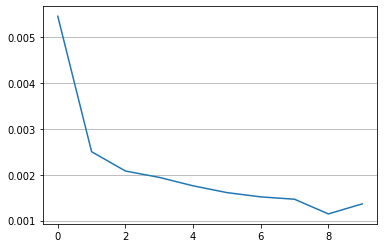

In [76]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.grid(axis = 'y');


## Evaluate on Test Data

In [77]:
scaled_train.shape

(1336, 1)

In [78]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_cols))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
#     current_batch = np.append(current_batch[:, 1:, :],[[current_pred]], axis = 1)
    current_batch = np.append(current_batch[:, 1:, :],[[scaled_test[i]]], axis = 1)

### Inverse Transformations and Compare

In [79]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions.shape, test.shape

((260, 1), (260, 1))

(260,)


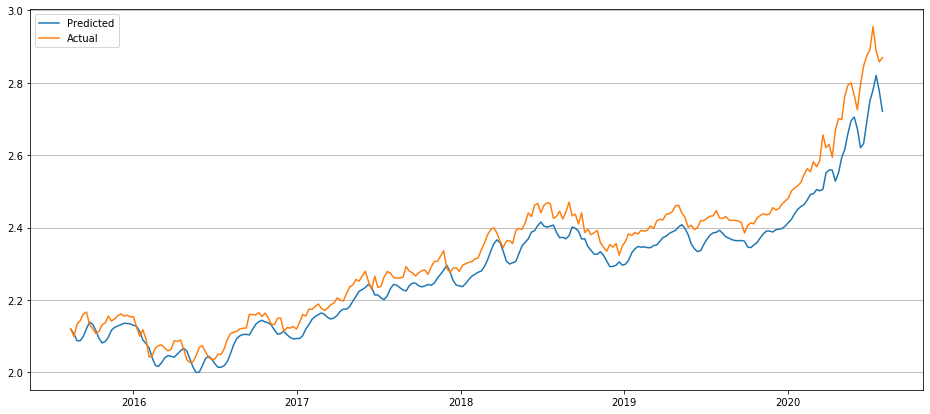

In [80]:
dates = wkly_nsdq_v_spx.index[-test.shape[0]:]
print(dates.shape)

plt.figure(figsize = (16, 7))
plt.plot(dates, true_predictions, label = 'Predicted')
plt.plot(dates, test, label = 'Actual')
plt.grid(axis = 'y')
plt.legend();

In [ ]:
# Room to improve the model...

### Hyperparameter search

- From the Generator section onwards in one block

In [81]:
def hyper_search(
    n_input, 
    n_nodes_list, 
    rate_dropout, 
    act_funct = 'relu', 
    opt = 'adam', 
    batch_size = 1,
    epochs = 25,
    patience = 2
):

    ## Time-Series Generator
    n_input = n_input 
    n_cols = scaled_train.shape[1]
    generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)


    ## Build LSTM model
    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            model.add(LSTM(n_nodes_list[layer], activation = act_funct, return_sequences = seq_bool[layer], input_shape = (n_input, n_cols)))
        else:
            model.add(LSTM(n_nodes_list[layer], activation = act_funct, return_sequences = seq_bool[layer]))
        if rate_dropout != 0:
            model.add(Dropout(rate = rate_dropout))
    
    model.add(Dense(1))
    model.compile(optimizer = opt, loss = 'mse')


    ## Fit LSTM model
    early_stopping = EarlyStopping(monitor = 'loss', patience = patience)
    model.fit_generator(generator, epochs = epochs, callbacks = [early_stopping])


    ## Generate Predictions
    test_predictions = []
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_cols))
    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred) 
        current_batch = np.append(current_batch[:, 1:, :],[[scaled_test[i]]], axis = 1)
    true_predictions = scaler.inverse_transform(test_predictions)

    return generator, model, true_predictions


In [82]:
# list_n_inputs = [4, 8, 12, 18, 26, 38, 52, 78, 104, 156]
# list_n_nodes_list = [[500], [300], [200, 200], [500, 200], [100, 200, 300], [400, 250, 100], [50, 50, 50, 50, 50]]
# list_rate_dropout = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]

list_n_inputs = [4, 8]
list_n_nodes_list = [[10], [10, 5], [2]]
list_rate_dropout = [0.0, 0.05]

len(list_n_inputs) * len(list_n_nodes_list) * len(list_rate_dropout)

12

In [83]:
search_dict = {}

for x in list_n_inputs:
    for y in list_n_nodes_list:
        for z in list_rate_dropout:
            search_dict[f'{x}_{y}_{z}'] = hyper_search(
                n_input = x, 
                n_nodes_list = y, 
                rate_dropout = z,
#                 epochs = 3
            )
#             print(f'{x}_{y}_{z}')

Epoch 1/25
1332/1332 [==============================] - 3s 2ms/step - loss: 0.0074
Epoch 2/25
1332/1332 [==============================] - 2s 2ms/step - loss: 9.4920e-04
Epoch 3/25
1332/1332 [==============================] - 2s 2ms/step - loss: 5.8753e-04
Epoch 4/25
1332/1332 [==============================] - 2s 2ms/step - loss: 4.7466e-04
Epoch 5/25
1332/1332 [==============================] - 2s 2ms/step - loss: 4.4126e-04
Epoch 6/25
1332/1332 [==============================] - 2s 2ms/step - loss: 4.3941e-04
Epoch 7/25
1332/1332 [==============================] - 2s 2ms/step - loss: 3.9748e-04
Epoch 8/25
1332/1332 [==============================] - 2s 2ms/step - loss: 3.4122e-04
Epoch 9/25
1332/1332 [==============================] - 2s 2ms/step - loss: 3.3801e-04
Epoch 10/25
1332/1332 [==============================] - 2s 2ms/step - loss: 3.4683e-04
Epoch 11/25
1332/1332 [==============================] - 2s 2ms/step - loss: 3.3262e-04
Epoch 12/25
1332/1332 [======================

1328/1328 [==============================] - 3s 3ms/step - loss: 2.8077e-04
Epoch 1/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0066
Epoch 2/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0023
Epoch 3/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0020
Epoch 4/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0018
Epoch 5/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0017
Epoch 6/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 7/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 8/25
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 9/25
1328/1328 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 10/25
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0012
Epoch 1/25
1328/1328 [==============================] - 6s 5ms/step - loss: 0.0317
Epoch 2/25

In [112]:
euclid_errors = pd.DataFrame()

for k, v in search_dict.items():
    error = np.linalg.norm((test - v[2]))
    euclid_errors.loc[k, 'error'] = error
    
euclid_errors.sort_values('error')

,error
8_[10]_0.0,0.374171
4_[2]_0.0,0.573326
4_[10]_0.0,0.689814
"8_[10, 5]_0.05",0.708844
8_[10]_0.05,0.732239
4_[10]_0.05,2.988532
8_[2]_0.0,12.907594
"4_[10, 5]_0.0",13.075160
8_[2]_0.05,13.197346
"8_[10, 5]_0.0",13.313454


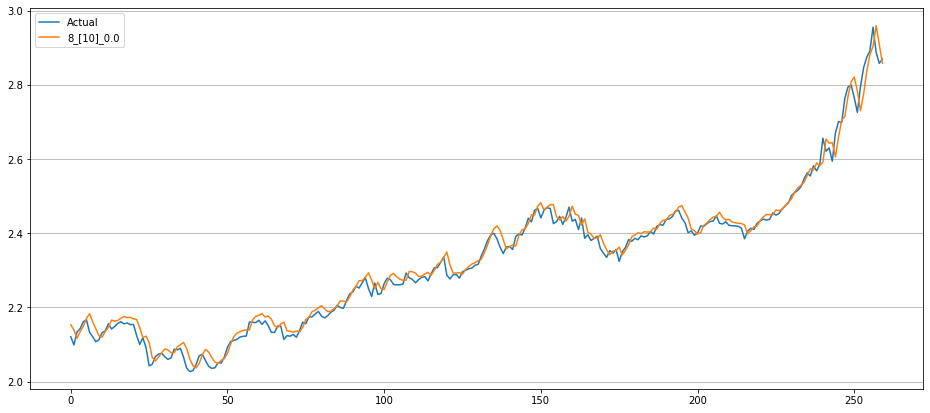

In [101]:
plt.figure(figsize = (16, 7))
plt.plot(test, label = 'Actual')

# plt.ylim(top = 3.2)
# for k, v in search_dict.items():
#     plt.plot(v[2], label = k)
    
# plt.plot(search_dict['4_[10]_0.0'][2], label = '4_[10]_0.0')
# plt.plot(search_dict['4_[10]_0.05'][2], label = '4_[10]_0.05')

## plt.plot(search_dict['4_[10, 5]_0.0'][2], label = '4_[10, 5]_0.0')
## plt.plot(search_dict['4_[10, 5]_0.05'][2], label = '4_[10, 5]_0.05')

# plt.plot(search_dict['4_[2]_0.0'][2], label = '4_[2]_0.0')
## plt.plot(search_dict['4_[2]_0.05'][2], label = '4_[2]_0.05')

plt.plot(search_dict['8_[10]_0.0'][2], label = '8_[10]_0.0')
# plt.plot(search_dict['8_[10]_0.05'][2], label = '8_[10]_0.05')

## plt.plot(search_dict['8_[10, 5]_0.0'][2], label = '8_[10, 5]_0.0')
# plt.plot(search_dict['8_[10, 5]_0.05'][2], label = '8_[10, 5]_0.05')

## plt.plot(search_dict['8_[2]_0.0'][2], label = '8_[2]_0.0')
## plt.plot(search_dict['8_[2]_0.05'][2], label = '8_[2]_0.05')
    
plt.legend(loc = 'best')
plt.grid(axis = 'y');
    

In [111]:
test.shape

(260, 1)

## Try more hyperparameters...

In [110]:
list_n_inputs = [8, 52, 104]
list_n_nodes_list = [[200], [100, 100], [100, 100, 100]]
list_rate_dropout = [0.0, 0.01]

print(len(list_n_inputs) * len(list_n_nodes_list) * len(list_rate_dropout))

search_dict2 = {}

for x in list_n_inputs:
    for y in list_n_nodes_list:
        for z in list_rate_dropout:
            search_dict2[f'{x}_{y}_{z}'] = hyper_search(
                n_input = x, 
                n_nodes_list = y, 
                rate_dropout = z,
            )
            
## This took aaaagggggeeeeeessss......

18
Epoch 1/25
1328/1328 [==============================] - 5s 4ms/step - loss: 0.0027
Epoch 2/25
1328/1328 [==============================] - 5s 3ms/step - loss: 8.5137e-04
Epoch 3/25
1328/1328 [==============================] - 4s 3ms/step - loss: 6.3822e-04
Epoch 4/25
1328/1328 [==============================] - 5s 3ms/step - loss: 5.9154e-04
Epoch 5/25
1328/1328 [==============================] - 6s 4ms/step - loss: 5.0555e-04
Epoch 6/25
1328/1328 [==============================] - 5s 4ms/step - loss: 4.1057e-04
Epoch 7/25
1328/1328 [==============================] - 5s 4ms/step - loss: 4.0336e-04
Epoch 8/25
1328/1328 [==============================] - 5s 4ms/step - loss: 3.7170e-04
Epoch 9/25
1328/1328 [==============================] - 5s 4ms/step - loss: 3.3358e-04
Epoch 10/25
1328/1328 [==============================] - 5s 4ms/step - loss: 3.5283e-04
Epoch 11/25
1328/1328 [==============================] - 5s 4ms/step - loss: 3.1359e-04
Epoch 12/25
1328/1328 [===================

1284/1284 [==============================] - 24s 19ms/step - loss: 4.2316e-04
Epoch 6/25
1284/1284 [==============================] - 22s 17ms/step - loss: 3.9213e-04
Epoch 7/25
1284/1284 [==============================] - 22s 18ms/step - loss: 3.7855e-04
Epoch 8/25
1284/1284 [==============================] - 24s 18ms/step - loss: 3.4973e-04
Epoch 9/25
1284/1284 [==============================] - 22s 17ms/step - loss: 3.3782e-04
Epoch 10/25
1284/1284 [==============================] - 22s 17ms/step - loss: 3.1202e-04
Epoch 11/25
1284/1284 [==============================] - 24s 19ms/step - loss: 3.5941e-04
Epoch 12/25
1284/1284 [==============================] - 22s 17ms/step - loss: 3.1750e-04
Epoch 1/25
1284/1284 [==============================] - 25s 19ms/step - loss: 0.0034
Epoch 2/25
1284/1284 [==============================] - 22s 17ms/step - loss: 0.0011
Epoch 3/25
1284/1284 [==============================] - 22s 17ms/step - loss: 6.4867e-04
Epoch 4/25
1284/1284 [===============

1232/1232 [==============================] - 73s 59ms/step - loss: 4.3806e-04
Epoch 9/25
1232/1232 [==============================] - 71s 57ms/step - loss: 4.3619e-04
Epoch 10/25
1232/1232 [==============================] - 70s 57ms/step - loss: 3.6946e-04
Epoch 11/25
1232/1232 [==============================] - 69s 56ms/step - loss: 3.4743e-04
Epoch 12/25
1232/1232 [==============================] - 70s 57ms/step - loss: 3.6288e-04
Epoch 13/25
1232/1232 [==============================] - 71s 58ms/step - loss: 3.8528e-04
Epoch 1/25
1232/1232 [==============================] - 74s 60ms/step - loss: 0.0037
Epoch 2/25
1232/1232 [==============================] - 73s 59ms/step - loss: 0.0015
Epoch 3/25
1232/1232 [==============================] - 73s 59ms/step - loss: 0.0011
Epoch 4/25
1232/1232 [==============================] - 76s 61ms/step - loss: 8.1599e-04
Epoch 5/25
1232/1232 [==============================] - 72s 58ms/step - loss: 9.2816e-04
Epoch 6/25
1232/1232 [==================

NameError: name 'euclid_errors' is not defined

In [113]:
for k, v in search_dict2.items():
    error = np.linalg.norm((test - v[2]))
    euclid_errors.loc[k, 'error'] = error
    
euclid_errors.sort_values('error')

,error
52_[200]_0.0,0.368613
8_[10]_0.0,0.374171
"104_[100, 100]_0.01",0.407671
"52_[100, 100]_0.0",0.409768
"8_[100, 100]_0.0",0.457718
"104_[100, 100, 100]_0.01",0.465942
52_[200]_0.01,0.476495
"52_[100, 100, 100]_0.0",0.504334
4_[2]_0.0,0.573326
104_[200]_0.0,0.590392


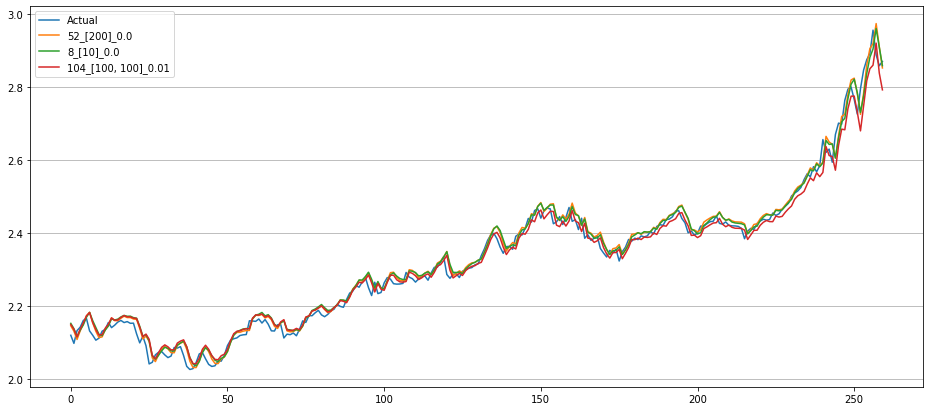

In [115]:
plt.figure(figsize = (16, 7))
plt.plot(test, label = 'Actual')

# for combo in euclid_errors.index[:3]:
#     plt.plot(search_dict2[combo][2], label = combo)

plt.plot(search_dict2['52_[200]_0.0'][2], label = '52_[200]_0.0')
plt.plot(search_dict['8_[10]_0.0'][2], label = '8_[10]_0.0')
plt.plot(search_dict2['104_[100, 100]_0.01'][2], label = '104_[100, 100]_0.01')
    
plt.legend(loc = 'best')
plt.grid(axis = 'y');

## Results:

The top performing combination of hyperparameters are: 

    1. 52 weeks of input data, one hidden layer of 200 nodes, 0% drop out 
    2. 8 weeks of input data, one hidden layer of 10 nodes, 0% drop out
    3. 104 weeks of input data, two hidden layers of 100 nodes each, 1% drop out

The mix of results show there is no dominant or consistent hyperparameter. That said the input of 52 weeks appears more frequently in the top of the table, suggesting there may be some seasonal non-linearity the model is identifying. 

Also notable was that combinations including some rate of dropout tended to perform worse. Its interesting because dropout is usually included to improve validation testing, where as the opposite happened here. 

Visually, it looks like there is a lagged response in the predicted values. A variation of the model could be to predict whether the return will be positive or negative (classification). Could then build a trading strading that generates buy/sell signals depending on the accuracy of the model...

In [116]:
search_dict.update(search_dict2)

In [118]:
search_dict.keys()

dict_keys(['4_[10]_0.0', '4_[10]_0.05', '4_[10, 5]_0.0', '4_[10, 5]_0.05', '4_[2]_0.0', '4_[2]_0.05', '8_[10]_0.0', '8_[10]_0.05', '8_[10, 5]_0.0', '8_[10, 5]_0.05', '8_[2]_0.0', '8_[2]_0.05', '8_[200]_0.0', '8_[200]_0.01', '8_[100, 100]_0.0', '8_[100, 100]_0.01', '8_[100, 100, 100]_0.0', '8_[100, 100, 100]_0.01', '52_[200]_0.0', '52_[200]_0.01', '52_[100, 100]_0.0', '52_[100, 100]_0.01', '52_[100, 100, 100]_0.0', '52_[100, 100, 100]_0.01', '104_[200]_0.0', '104_[200]_0.01', '104_[100, 100]_0.0', '104_[100, 100]_0.01', '104_[100, 100, 100]_0.0', '104_[100, 100, 100]_0.01'])

In [119]:
import pickle

f = open('../Data/Data/qqq_spx_search_dict.pkl', 'wb')
pickle.dump(search_dict, f)
f.close()